In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import yaml
import pickle as pk
import json

%matplotlib inline

In [4]:
%cd c:\Users\CARNOT\Water_Portability_Prediction

c:\Users\CARNOT\Water_Portability_Prediction


In [32]:
with open("params.yaml") as file:
    config = yaml.safe_load(file)

In [6]:
df = pd.read_csv(r"data\raw\water_potability.csv")

In [16]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [74]:
X = df.drop(columns="Potability")
y = df["Potability"]

In [75]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=234)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [57]:
test = X_test

In [58]:
test.to_csv(config["paths"]["test_data"], index=False)

In [12]:
print(y_train.shape)
print(y_test.shape)

(2620,)
(656,)


In [13]:
y_train.value_counts(normalize=True)

0    0.609924
1    0.390076
Name: Potability, dtype: float64

In [76]:
# imblance
def imblearn(X_train, y_train):
    imputer = SimpleImputer(strategy="median")
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    resample = SMOTE(random_state=234, k_neighbors=10)
    X_train, y_train = resample.fit_resample(X_train, y_train)
    return X_train, y_train

In [77]:
X_train, y_train = imblearn(X_train=X_train, y_train=y_train)

In [23]:
y_train.value_counts()

0    1598
1    1598
Name: Potability, dtype: int64

In [24]:
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: Potability, dtype: float64

In [25]:
# standard scaling
scaler = StandardScaler()

In [26]:
# Imputer
imputer = SimpleImputer(strategy="median")

In [27]:
# random forest model
model_rf = RandomForestClassifier(random_state=234)

In [10]:
# xgboost model
model_xgb = XGBClassifier(random_state=234)

In [11]:
# lightgbm model
model_lgbm = LGBMClassifier(random_state=234)

In [40]:
# Extra tree
model_extra_tree = ExtraTreeClassifier(random_state=234)
clf = BaggingClassifier(model_extra_tree, random_state=234)

In [40]:
# random forest pipeline
pipe_rf = make_pipeline(imputer, scaler, model_rf)

In [46]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=234))])

In [ ]:
# n_estimators=100, *, criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0, max_features="sqrt", max_leaf_nodes=None, min_impurity_decrease=0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0, max_samples=None

In [37]:
print(dir(pipe_rf))

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_can_inverse_transform', '_can_transform', '_check_feature_names', '_check_fit_params', '_check_n_features', '_estimator_type', '_final_estimator', '_fit', '_get_param_names', '_get_params', '_get_tags', '_iter', '_log_message', '_more_tags', '_replace_estimator', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_set_params', '_sk_visual_block_', '_validate_data', '_validate_names', '_validate_steps', 'classes_', 'decision_function', 'feature_names_in_', 'fit', 'fit_predict', 'fi

In [50]:
print(pipe_rf.get_params())

{'memory': None, 'steps': [('simpleimputer', SimpleImputer(strategy='median')), ('standardscaler', StandardScaler()), ('randomforestclassifier', RandomForestClassifier(random_state=234))], 'verbose': False, 'simpleimputer': SimpleImputer(strategy='median'), 'standardscaler': StandardScaler(), 'randomforestclassifier': RandomForestClassifier(random_state=234), 'simpleimputer__add_indicator': False, 'simpleimputer__copy': True, 'simpleimputer__fill_value': None, 'simpleimputer__missing_values': nan, 'simpleimputer__strategy': 'median', 'simpleimputer__verbose': 'deprecated', 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'randomforestclassifier__bootstrap': True, 'randomforestclassifier__ccp_alpha': 0.0, 'randomforestclassifier__class_weight': None, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_leaf_nodes': None, 'rando

In [59]:
param = {
            "randomforestclassifier__n_estimators":range(50, 200, 25),
            "randomforestclassifier__criterion": ["gini", "entropy", "log_loss"],
            "randomforestclassifier__max_depth": range(4, 15, 2),
            "randomforestclassifier__min_samples_split": range(2, 10, 2),
            "randomforestclassifier__min_samples_leaf": range(1, 10, 1),
            "randomforestclassifier__max_features": ["sqrt", "log"],
            "simpleimputer__strategy": ["median", "mean"]
        }
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=234)

In [56]:
import sklearn.metrics as sm
print(sm.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [60]:

rgrid = RandomizedSearchCV(estimator=make_pipeline(imputer, model_rf), param_distributions=param, cv=cv, n_jobs=-1, n_iter=20, scoring="accuracy")
rgrid.fit(X_train, y_train)

C:\Users\CARNOT\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\CARNOT\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CARNOT\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CARNOT\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py",

RandomizedSearchCV(cv=StratifiedKFold(n_splits=20, random_state=234, shuffle=True),
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=234))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': range(4, 15, 2),
                                        'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log'],
                                        'randomforestclassifier__min_samples_leaf': range(1, 10),
                                        'randomforestclassifier__min_samples_split': range(2, 10, 2),
                                        'randomforestclassifier__n_estimators': range(50, 200, 25),
                                        'simpleimputer__strategy': ['median',
                                                                    'mean']},
                   scoring='accuracy')

In [ ]:
with open(config["paths"]["model"], "wb") as file:
    pk.dump(pipe_rf, file)

In [ ]:
print('saving the model to ' + config["paths"]["model"] + "...")

saving the model to model/model.pk...


In [30]:
metrics = classification_report(y_test, pipe_rf.predict(X_test))
print(metrics)

              precision    recall  f1-score   support

           0       0.71      0.74      0.72       400
           1       0.56      0.52      0.54       256

    accuracy                           0.65       656
   macro avg       0.63      0.63      0.63       656
weighted avg       0.65      0.65      0.65       656



In [ ]:
with open(config["paths"]["metrics"], "w") as file:
    json.dump({"metrics": metrics}, file)

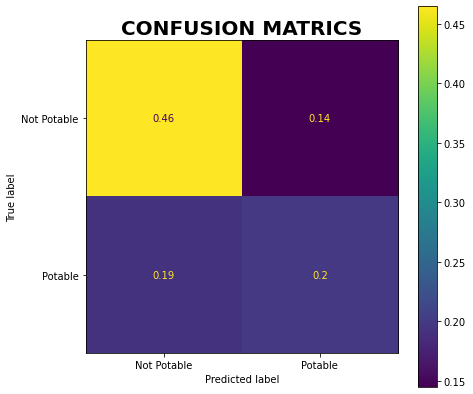

In [53]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test, normalize='all', labels=[0, 1], display_labels=["Not Potable", "Potable"], ax=ax)
plt.title("Confusion Matrics".upper(), size=20, weight="bold")
plt.savefig(config["paths"]["confusion_matrix"])

In [45]:
pipe_rf.predict_proba(X_test)[:, 0]

array([0.72, 0.39, 0.69, 0.5 , 0.34, 0.35, 0.21, 0.56, 0.65, 0.68, 0.64,
       0.67, 0.87, 0.51, 0.65, 0.52, 0.57, 0.66, 0.74, 0.51, 0.37, 0.47,
       0.61, 0.43, 0.37, 0.61, 0.49, 0.43, 0.64, 0.53, 0.48, 0.65, 0.5 ,
       0.65, 0.4 , 0.54, 0.56, 0.63, 0.43, 0.34, 0.67, 0.78, 0.52, 0.53,
       0.77, 0.52, 0.42, 0.67, 0.87, 0.59, 0.26, 0.57, 0.64, 0.28, 0.44,
       0.59, 0.61, 0.76, 0.55, 0.55, 0.5 , 0.59, 0.58, 0.46, 0.29, 0.4 ,
       0.6 , 0.71, 0.67, 0.72, 0.26, 0.51, 0.77, 0.35, 0.6 , 0.6 , 0.65,
       0.66, 0.62, 0.83, 0.46, 0.57, 0.73, 0.54, 0.64, 0.4 , 0.75, 0.41,
       0.51, 0.59, 0.71, 0.56, 0.69, 0.49, 0.85, 0.52, 0.58, 0.51, 0.69,
       0.67, 0.62, 0.35, 0.35, 0.3 , 0.53, 0.74, 0.59, 0.54, 0.52, 0.75,
       0.7 , 0.69, 0.56, 0.61, 0.62, 0.37, 0.61, 0.46, 0.66, 0.27, 0.61,
       0.45, 0.74, 0.6 , 0.69, 0.32, 0.77, 0.62, 0.66, 0.44, 0.62, 0.63,
       0.29, 0.6 , 0.42, 0.59, 0.32, 0.59, 0.63, 0.47, 0.47, 0.42, 0.38,
       0.36, 0.78, 0.44, 0.71, 0.59, 0.66, 0.63, 0.

In [42]:
y_test.values.shape

(656,)

In [46]:
fpr, tpr, thresholds = roc_curve(y_test.values, pipe_rf.predict_proba(X_test)[:,0])

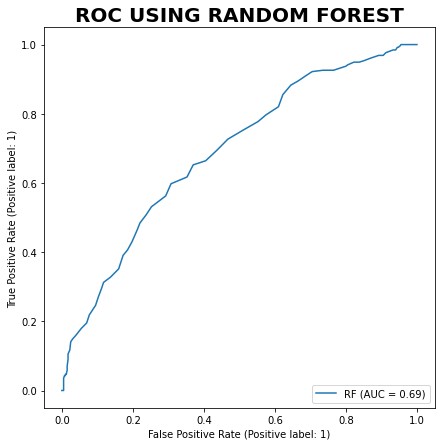

In [54]:
fig, ax = plt.subplots(figsize=(7,7))
RocCurveDisplay.from_estimator(estimator=pipe_rf, X=X_test, y=y_test, pos_label=1, name="RF", ax=ax)
plt.title("ROC using Random Forest".upper(), size=20, weight="bold")
plt.savefig(config["paths"]["roc_curve"]);

In [30]:
# random forest pipeline
pipe_xgb = make_pipeline(imputer, scaler, model_xgb)

In [31]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=234, reg_alpha=0,
                               reg_lambda=1, ...))])

In [32]:
print(classification_report(y_test, pipe_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       400
           1       0.52      0.54      0.53       256

    accuracy                           0.63       656
   macro avg       0.61      0.61      0.61       656
weighted avg       0.63      0.63      0.63       656



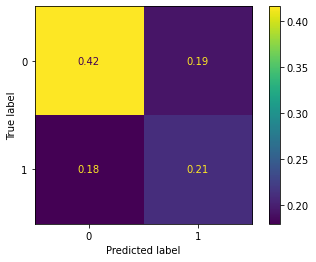

In [33]:
ConfusionMatrixDisplay.from_estimator(pipe_xgb, X_test, y_test, normalize='all')

In [34]:
# random forest pipeline
pipe_lgbm = make_pipeline(imputer, scaler, model_lgbm)

In [35]:
pipe_lgbm.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier(random_state=234))])

In [36]:
print(classification_report(y_test, pipe_lgbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.69      0.69       400
           1       0.53      0.54      0.53       256

    accuracy                           0.63       656
   macro avg       0.61      0.62      0.61       656
weighted avg       0.63      0.63      0.63       656



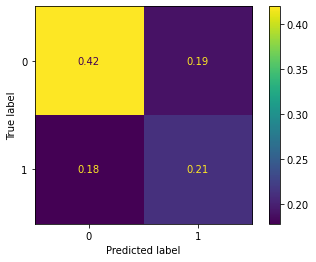

In [37]:
ConfusionMatrixDisplay.from_estimator(pipe_lgbm, X_test, y_test, normalize='all')

In [41]:
# random forest pipeline
pipe_extra_tree = make_pipeline(imputer, scaler, clf)

In [42]:
pipe_extra_tree.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=ExtraTreeClassifier(random_state=234),
                                   random_state=234))])

In [43]:
print(classification_report(y_test, pipe_extra_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.73      0.71       400
           1       0.53      0.46      0.49       256

    accuracy                           0.63       656
   macro avg       0.60      0.60      0.60       656
weighted avg       0.62      0.63      0.62       656



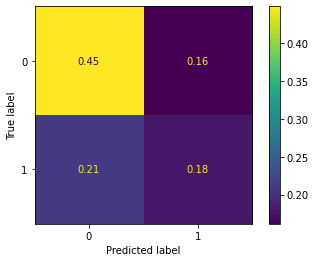

In [44]:
ConfusionMatrixDisplay.from_estimator(pipe_extra_tree, X_test, y_test, normalize='all')

In [46]:
estimators = [("rf", pipe_rf), 
              ("lgbm", pipe_lgbm), 
              ("xgb", pipe_xgb), 
              ("extra_tree", pipe_extra_tree)
              ]
stack = StackingClassifier(estimators=estimators, final_estimator=pipe_rf, cv=10, verbose=0, n_jobs=-1)
stack.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('rf',
                                Pipeline(steps=[('simpleimputer',
                                                 SimpleImputer(strategy='median')),
                                                ('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(random_state=234))])),
                               ('lgbm',
                                Pipeline(steps=[('simpleimputer',
                                                 SimpleImputer(strategy='median')),
                                                ('standardscaler',
                                                 StandardScaler()),
                                                ('lgbmclassifier',
                                                 LGBM...
                                                ('standardscaler',
                                                 StandardScaler()),
                                                ('baggingclassifier',
                                                 BaggingClassifier(base_estimator=ExtraTreeClassifier(random_state=234),
                                                                   random_state=234))]))],
                   final_estimator=Pipeline(steps=[('simpleimputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('standardscaler',
                                                    StandardScaler()),
                                                   ('randomforestclassifier',
                                                    RandomForestClassifier(random_state=234))]),
                   n_jobs=-1)

In [47]:
print(classification_report(y_test, stack.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       400
           1       0.52      0.48      0.50       256

    accuracy                           0.62       656
   macro avg       0.60      0.60      0.60       656
weighted avg       0.62      0.62      0.62       656



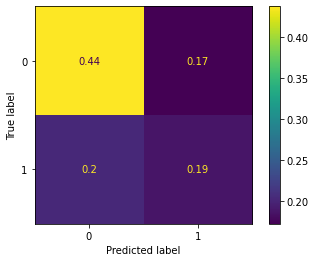

In [48]:
ConfusionMatrixDisplay.from_estimator(stack, X_test, y_test, normalize='all')

In [86]:
def feedforward():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=6, activation='relu'))
    model.add(tf.keras.layers.Dense(units=6, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    return model

In [87]:
clf = KerasClassifier(feedforward, loss='binary_crossentropy', optimizer='adam', batch_size = 32, metrics=['accuracy'],  epochs = 100)

In [88]:
model_pipe = Pipeline([("scaler",scaler), ("clf",clf)])

In [90]:
history = model_pipe.fit(X_train, y_train)

TypeError: object of type 'NoneType' has no len()